In [44]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transforms
import os

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [46]:
train_dir = '/kaggle/input/reduced/dogs-vs-cats/train'
test_dir = '/kaggle/input/reduced/dogs-vs-cats/test'

In [47]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
    class_names = train_data.classes

  # Turn images into data loaders
    train_dataloader = DataLoader(
          train_data,
          batch_size=batch_size,
          shuffle=True,
          num_workers=num_workers,
          pin_memory=True,
      )
    test_dataloader = DataLoader(
          test_data,
          batch_size=batch_size,
          shuffle=False,
          num_workers=num_workers,
          pin_memory=True,
      )

    return train_dataloader, test_dataloader, class_names

In [48]:
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [49]:
BATCH_SIZE = 4

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7eaa7648aef0>,
 ['cats', 'dogs'])

torch.Size([3, 224, 224]) tensor(1)


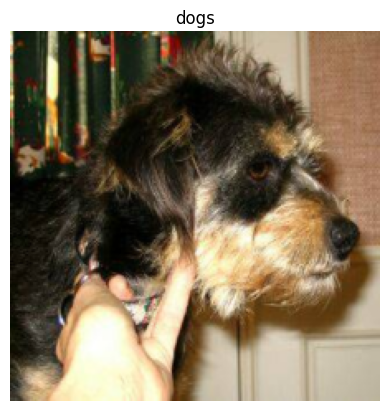

In [50]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

print(image.shape, label)

plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

Displaying an image from the train data loader:


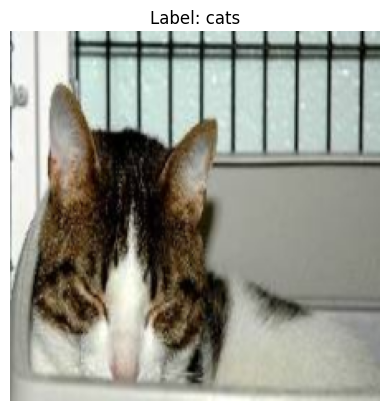

Displaying an image from the test data loader:


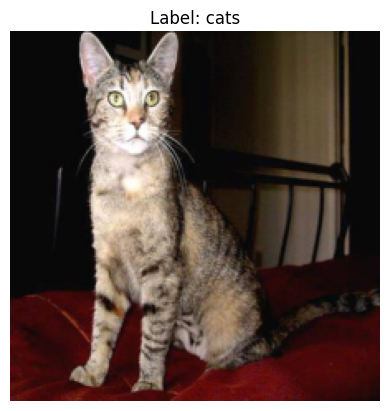

In [51]:
def show_image(data_loader):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    img = np.transpose(images[0].numpy(), (1, 2, 0))
    plt.imshow(img)
    plt.title(f'Label: {class_names[labels[0]]}')
    plt.axis('off')
    plt.show()

# Display an image from the train data loader
print("Displaying an image from the train data loader:")
show_image(train_dataloader)

# Display an image from the test data loader
print("Displaying an image from the test data loader:")
show_image(test_dataloader)

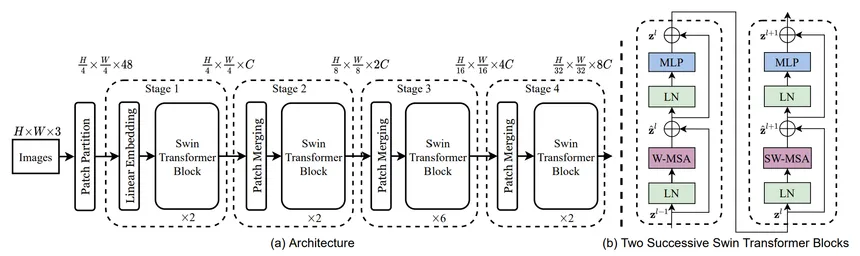

# **Swin Transformer step by step**

In [52]:
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

## **WINDOW PARTITION**

In [53]:
def window_partition(x, patch_size=4):
    
    B, H, W, C = x.shape
    
    # Calculate the number of patches in each dimension
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    
    # Convert to (B, num_patches_h, patch_size, num_patches_w, patch_size, C) 
    x = x.view(B, num_patches_h, patch_size, num_patches_w, patch_size, C)
    
    # Convert to (B, num_patches_h, num_patches_w, patch_size, patch_size, C)
    patches = x.permute(0, 1, 3, 2, 4, 5).contiguous()
    
    # Efficient Batch Computation - Convert to (B * num_patches_h * num_patches_w, patch_size, patch_size, C)
    patches = patches.view(-1, patch_size, patch_size, C)
    
    return patches

## **PATCH PARTITION + LINEAR EMBEDDING**

In [54]:
class PatchEmbed(nn.Module):
    
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size) # (img_size, img_size) to_2tuple simply convert t to (t,t)
        patch_size = to_2tuple(patch_size) # (patch_size, patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]] # (num_patches, num_patches)
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]
        
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        # proj layer: (B, 3, 224, 224) -> (B, 96, 56, 56)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None
        
    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}]) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        
        # (B, 3, 224, 224) -> (B, 96, 56, 56)
        x = self.proj(x)
        
        x = x.flatten(2)
        
        x = x.transpose(1, 2)
        
        if self.norm is not None:
            x = self.norm(x)
        
        return x

## **WINDOW REVERSE**

In [55]:
def window_reverse(windows, window_size, H, W):
    
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
    
    x = x.view(B, H, W, -1)
    
    return x

In [56]:
import random
from PIL import Image

classes = os.listdir(test_dir)
random_class = random.choice(classes)
class_images = os.listdir(os.path.join(test_dir, random_class))
random_image_name = random.choice(class_images)
random_image_path = os.path.join(test_dir, random_class, random_image_name)
image = Image.open(random_image_path)

tensor_image = manual_transforms(image)
tensor_image = tensor_image.unsqueeze(0) 
patch_embed = PatchEmbed(img_size=(224, 224), patch_size=(4, 4), in_chans=3, embed_dim=96)
embedding = patch_embed(tensor_image)
patches = patch_embed(tensor_image) 

print("Patches shape:", patches.shape)   

embedding

Patches shape: torch.Size([1, 3136, 96])


tensor([[[ 0.3596, -0.1039,  0.1109,  ..., -0.1403, -0.2526,  0.5478],
         [ 0.4232, -0.1017,  0.1033,  ..., -0.1653, -0.3406,  0.6031],
         [ 0.4038, -0.0995,  0.1267,  ..., -0.1226, -0.3260,  0.6514],
         ...,
         [ 0.3637, -0.0924,  0.1063,  ..., -0.1362, -0.3149,  0.5130],
         [ 0.3727, -0.0944,  0.0762,  ..., -0.1226, -0.3045,  0.5486],
         [ 0.3931, -0.0931,  0.1446,  ..., -0.1357, -0.2747,  0.6088]]],
       grad_fn=<TransposeBackward0>)

In [57]:
print("First patch embedding vector:", patches[0, 0])

First patch embedding vector: tensor([ 0.3596, -0.1039,  0.1109,  0.1485, -0.3397, -0.4361,  0.1097,  0.2488,
        -0.2045,  0.5114,  0.2504,  0.1207, -0.1208,  0.2920, -0.2498,  0.2560,
         0.0706,  0.3188, -0.2760,  0.4212,  0.0693, -0.0376, -0.3506,  0.2692,
        -0.1978,  0.7490, -0.1343,  0.0415,  0.1591,  0.1502,  0.0289,  0.3712,
         0.0077,  0.5982,  0.0429, -0.1834, -0.5543, -0.4139,  0.2693,  0.1560,
         0.2388,  0.0936, -0.0790,  0.3981,  0.2189,  0.0615,  0.1284, -0.1325,
         0.2665, -0.4158,  0.1482,  0.0791, -0.2004,  0.2552,  0.0380,  0.5410,
         0.3116, -0.3752,  0.1897,  0.5256, -0.3518, -0.0121,  0.3761, -1.0413,
         0.0665, -0.1008,  0.1023, -0.2133, -0.0227,  0.4633, -0.3132, -0.3906,
         0.0234,  0.2111,  0.0014, -0.4169, -0.0150,  0.1528, -0.0121,  0.3912,
         0.4516,  0.2891,  0.4431, -0.4603,  0.1012,  0.2751, -0.5524, -0.0182,
         0.2594,  0.0680,  0.4918, -0.2179, -0.0252, -0.1403, -0.2526,  0.5478],
       gr

## **Window Attention**

In [58]:
class WindowAttention(nn.Module):

    
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size  # (7,7)
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        
        # stores q,k,v biases values in table
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads)
        )
        
        # Pair-wise relative position index in window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w])) 
        coords_flatten = torch.flatten(coords, 1) 
        
        # Addding a new dimension for flattened part
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        
        # down permute used to change (2, pos, pos) -> (pos, pos, 2)
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += self.window_size[0] - 1 # make it start from 0 index
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1 # w.r.t x-axis
        
        # x-axis + y-axis
        relative_position_index = relative_coords.sum(-1) # (M^2, M^2)
        
        self.register_buffer('relative_position_index', relative_position_index)
        
        # Attention
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias) # W_Q, W_K, W_V
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        
        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)
        
    
    def forward(self, x, mask=None):
    
        # (batch, M^2, C)   # m = no.of positions
        B_, N, C = x.shape
        
        # (num_windows*B, N, nC)  # n = value from n-diff i/p
        qkv = self.qkv(x)
        
        # 3 refers rel pos of vertical,horiz,spatial(2D) elements
        qkv = qkv.reshape(B_, N, 3, self.num_heads, C // self.num_heads)

        qkv = qkv.permute(2, 0, 3, 1, 4)
        
        
        q, k, v = qkv[0], qkv[1], qkv[2] 
        
        q = q * self.scale
        
        
        attn = np.matmul(q , k.transpose(-2, -1))
  
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1],  -1
        )
        
        # Convert to (num_heads, pos, pos) to match the dimension 
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        
    
        attn = attn + relative_position_bias.unsqueeze(0)
        
        if mask is not None:
            nW = mask.shape[0] 
            
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)
            
        attn = self.attn_drop(attn)
        
        x = matmul(attn , v).transpose(1, 2).reshape(B_, N, C)
        
        # Projection Matrix (W_0). dim doesn't change since we used C // num_heads for MSA
        # x = (B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x        

## **MLP**

In [59]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act_layer = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act_layer(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
		

## **SWIN TRANSFORMER BLOCK**

In [60]:
class SwinTransformerBlock(nn.Module):

    
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm
                ):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        
        # If window_size > input_resolution, no partition
        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"
        
        self.norm1 = norm_layer(dim)
        
        # Attention
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop
        )
        
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        
        # MLP
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        
        # Attention Mask for SW-MSA
        # This handling of attention-mask is my favourite part. What a beautiful implementation.
        if self.shift_size > 0:
            H, W = self.input_resolution
            
            # To match the dimension for window_partition function
            img_mask = torch.zeros((1, H, W, 1))
            
            # h_slices and w_slices divide a cyclic-shifted image to 9 regions as shown in the paper
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None)
            )
            
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None)
            )
            
            # Fill out number for each of 9 divided regions
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
                    
            mask_windows = window_partition(img_mask, self.window_size) # (nW, M, M, 1)
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            
            # Such a gorgeous code..
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None
            
        self.register_buffer('attn_mask', attn_mask)
        
    
    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        
        shortcut = x # Residual
        x = self.norm1(x)
        x = x.view(B, H, W, C) # H, W refer to the number of "patches" for width and height, not "pixels"
        
        # Cyclic Shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x
        
        # Partition Windows
        x_windows = window_partition(shifted_x, self.window_size) # (nW*B, M, M, C)
        x_windows = x_windows.view(-1, self.window_size*self.window_size, C) # (nW*B, window_size*window_size, C)
        
        # W-MSA / SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask) # (nW*B, window_size*window_size, C)
        
        # Merge Windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W) # (B, H', W', C)
        
        # Reverse Cyclic Shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H*W, C)
        
        # FFn
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        
        return x

## **PATCH MERGING**

In [61]:
class PatchMerging(nn.Module):
    
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)
        
    def forward(self, x):
        # (B, H*W, C)
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."
        
        x = x.view(B, H, W, C)
        
        # Separate per patch by 2 x 2
        x0 = x[:, 0::2, 0::2, :] # (top-left of 2x2)
        x1 = x[:, 1::2, 0::2, :] # (bottom-left of 2x2)
        x2 = x[:, 0::2, 1::2, :] # (top-right of 2x2)
        x3 = x[:, 1::2, 1::2, :] #  (bottom-right of 2x2)
        
        # Merge by channel -> (B, H/2, W/2, 4C)   # Merging 4 patches- thats why 4C
        x = torch.cat([x0, x1, x2, x3], -1)
        
        # Flatten H, W
        x = x.view(B, -1, 4 * C)
        
        x = self.norm(x)
        
        # Reduction Layer: 4C -> 2C
        x = self.reduction(x)
        
        return x

## **Basic layer means contains patchmerging+SWT block**

In [62]:
class BasicLayer(nn.Module):
   
    
    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        
        # Build  Swin-Transformer Blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio = mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer
                                )
            for i in range(depth)
        ])
        
        
        # Patch Merging Layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None
            
            
    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        
        if self.downsample is not None:
            x = self.downsample(x)
        
        return x
    

## **Bringing all together**

In [63]:
class SwinTransformer(nn.Module):
    
    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__()
        
        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio
        
        # Split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None
        )
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution
        
        self.pos_drop = nn.Dropout(p=drop_rate)
        
        # Stochastic Depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] # stochastic depth decay rule
        
        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2 ** i_layer),
                input_resolution=(
                    patches_resolution[0] // (2 ** i_layer), # After patch-merging layer, patches_resolution(H, W) is halved
                    patches_resolution[1] // (2 ** i_layer),
                                 ),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=window_size,
                mlp_ratio=self.mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                norm_layer=norm_layer,
                downsample=PatchMerging if (i_layer < self.num_layers -1) else None, # No patch merging at the last stage
                use_checkpoint=use_checkpoint
            )
            
            self.layers.append(layer)
            
        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        
        # Classification Head
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        
        self.apply(self._init_weights)
        
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
    
    
    def forward_features(self, x):
        x = self.patch_embed(x)
        # if self.ape:
        #     x = x + self.absolute_pos_embed
        x = self.pos_drop(x)
        
        for layer in self.layers:
            x = layer(x)
            
        x = self.norm(x) # (B, L, C)
        x = self.avgpool(x.transpose(1, 2)) # (B, C, 1)
        x = torch.flatten(x, 1)
        return x
    
    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x
    

In [64]:
stage_1 = BasicLayer(dim=96, input_resolution=(56, 56), depth=2, num_heads=4, window_size=7)

# Pass the patch embeddings through the BasicLayer
output = stage_1(embedding)
print(output.shape)
output

torch.Size([1, 3136, 96])


tensor([[[ 0.4020,  0.2124,  0.1853,  ..., -0.3333,  0.0071,  0.8087],
         [ 0.4822,  0.1956,  0.1739,  ..., -0.4003, -0.0947,  0.8359],
         [ 0.4267,  0.2111,  0.1820,  ..., -0.3795, -0.0781,  0.9281],
         ...,
         [ 0.4667,  0.1300,  0.2076,  ..., -0.4009, -0.0109,  0.7311],
         [ 0.4678,  0.1439,  0.1594,  ..., -0.3926,  0.0024,  0.8018],
         [ 0.4508,  0.1497,  0.2545,  ..., -0.4357,  0.0593,  0.9063]]],
       grad_fn=<AddBackward0>)

## **Patch Merging**

In [65]:
merge_layer = PatchMerging(input_resolution=(56, 56), dim=96, norm_layer=nn.LayerNorm)
merged_output = merge_layer(output)
print("Merged output shape:", merged_output.shape)
## (1, 28x28, 96*2) # (1, 784, 192)

Merged output shape: torch.Size([1, 784, 192])


In [66]:
batch_size = merged_output.shape[0]
num_patches = merged_output.shape[1]
num_channels = merged_output.shape[2]

print("Batch size:", batch_size)
print("Number of patches:", num_patches)
print("Number of channels:", num_channels)

Batch size: 1
Number of patches: 784
Number of channels: 192


### **Stage-1 of the Swin-T architecture using SwinTransformerBlock:**

In [67]:
block_1 = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=0,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


#  shift_size is set to 3
block_1_shf = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=2,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)

In [68]:
output = block_1(embedding)
output_shf = block_1_shf(embedding)

print(output.shape)
print(output_shf.shape)
print(output)
print(output_shf)

torch.Size([1, 3136, 96])
torch.Size([1, 3136, 96])
tensor([[[ 0.3093, -0.2723, -0.1622,  ..., -0.4182, -0.5091,  0.5835],
         [ 0.3735, -0.3042, -0.1703,  ..., -0.4192, -0.5839,  0.6481],
         [ 0.3304, -0.2909, -0.1536,  ..., -0.3807, -0.5845,  0.7014],
         ...,
         [ 0.2726, -0.3455, -0.1720,  ..., -0.3992, -0.5359,  0.5587],
         [ 0.2855, -0.3381, -0.2054,  ..., -0.3870, -0.5209,  0.5857],
         [ 0.2651, -0.3189, -0.1581,  ..., -0.3942, -0.4863,  0.6482]]],
       grad_fn=<AddBackward0>)
tensor([[[-0.0503, -0.5003,  0.0794,  ..., -0.0838,  0.3003,  1.1971],
         [-0.0032, -0.5168,  0.1193,  ..., -0.0973,  0.2099,  1.2833],
         [-0.0019, -0.4561,  0.1140,  ..., -0.0861,  0.2162,  1.3354],
         ...,
         [-0.0562, -0.4795,  0.1107,  ..., -0.1268,  0.2186,  1.1904],
         [-0.0177, -0.4811,  0.0455,  ..., -0.1264,  0.2254,  1.2168],
         [ 0.0091, -0.4659,  0.1180,  ..., -0.1380,  0.2552,  1.2604]]],
       grad_fn=<AddBackward0>)


In [69]:
model = SwinTransformer()

print(tensor_image.shape)

model(tensor_image).shape

torch.Size([1, 3, 224, 224])


torch.Size([1, 1000])

In [70]:
import sys
sys.path.append("/kaggle/input/going-modular/going_modular")

In [71]:
model = SwinTransformer(num_classes=len(class_names))

In [72]:
import engine

optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=3e-3, 
                             betas=(0.9, 0.999), 
                             weight_decay=0.3) 

loss_fn = torch.nn.CrossEntropyLoss()

torch.manual_seed(42)

# Train the model and save the training results to a dictionary
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8301 | train_acc: 0.4925 | test_loss: 0.6978 | test_acc: 0.5000
Epoch: 2 | train_loss: 0.6945 | train_acc: 0.4895 | test_loss: 0.6933 | test_acc: 0.5000
Epoch: 3 | train_loss: 0.6933 | train_acc: 0.4940 | test_loss: 0.6940 | test_acc: 0.5000
Epoch: 4 | train_loss: 0.6937 | train_acc: 0.4860 | test_loss: 0.6933 | test_acc: 0.5000
Epoch: 5 | train_loss: 0.6936 | train_acc: 0.4880 | test_loss: 0.6932 | test_acc: 0.5000
Epoch: 6 | train_loss: 0.6932 | train_acc: 0.5050 | test_loss: 0.6936 | test_acc: 0.5000
Epoch: 7 | train_loss: 0.6938 | train_acc: 0.4740 | test_loss: 0.6934 | test_acc: 0.5000
Epoch: 8 | train_loss: 0.6932 | train_acc: 0.5110 | test_loss: 0.6932 | test_acc: 0.5000
Epoch: 9 | train_loss: 0.6936 | train_acc: 0.4890 | test_loss: 0.6932 | test_acc: 0.5000
Epoch: 10 | train_loss: 0.6934 | train_acc: 0.5090 | test_loss: 0.6937 | test_acc: 0.5000


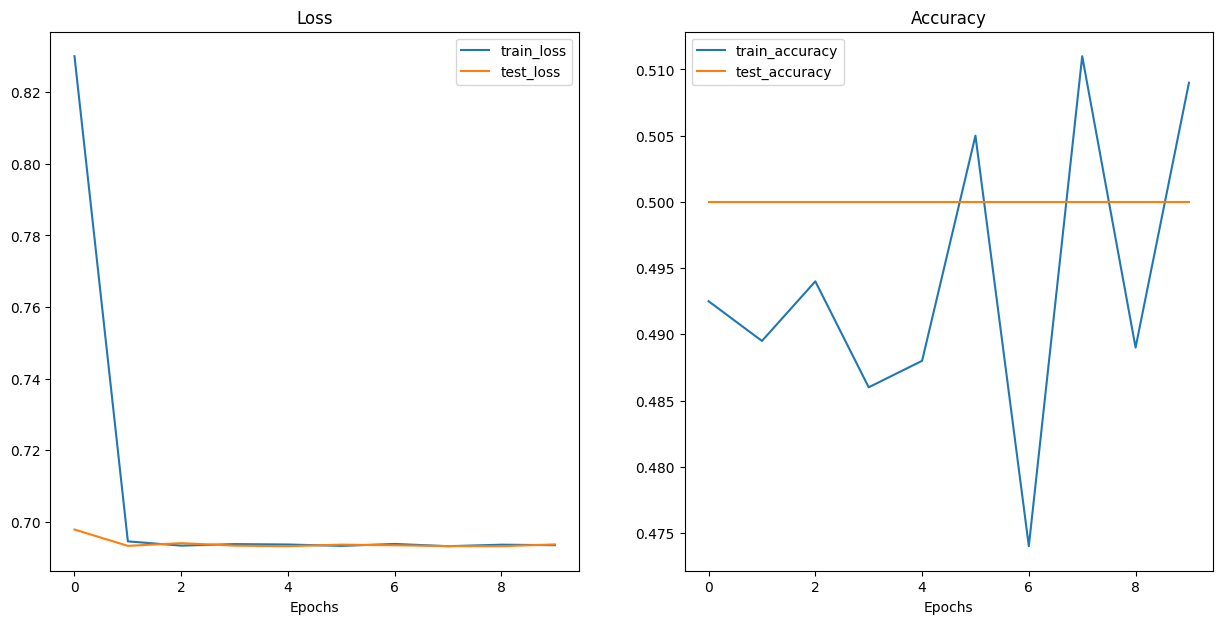

In [73]:
def plot_loss_curves(results):
    
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


plot_loss_curves(results)

Selected image path: /kaggle/input/reduced/dogs-vs-cats/test/cats/cat.11502.jpg


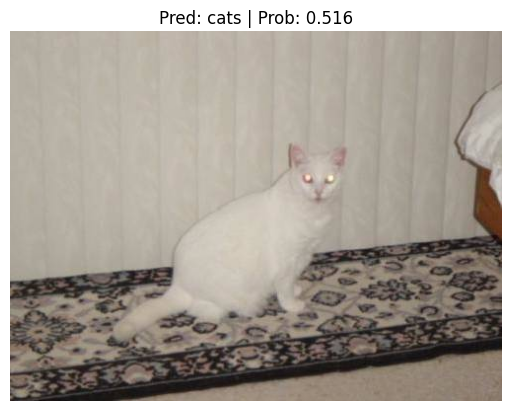

In [76]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Tuple
import random
from pathlib import Path

def pred_and_plot_image(
   model: torch.nn.Module,
   class_names: List[str],
   image_path: str,
   image_size: Tuple[int, int] = (224, 224),
   transform: transforms = None,
   device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    img = Image.open(image_path)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
           transforms.Resize(image_size),
           transforms.ToTensor(),
           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
       ])

    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))
        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label.item()]} | Prob: {target_image_pred_probs.max().item():.3f}")
    plt.axis(False)

test_folder = Path("/kaggle/input/reduced/dogs-vs-cats/test")
all_files = list(test_folder.glob('*/*'))
random_image_path = random.choice(all_files)
print(f"Selected image path: {random_image_path}")
pred_and_plot_image(model=model, image_path=str(random_image_path), class_names=class_names)